In [16]:
import pandas as pd
# df = pd.read_csv("experiments/data/thyroid/ann-train.data", sep=" ", header=None)
data_bupa = pd.read_csv("experiments/data/liver_disorders/bupa.data", sep=",", header=None, names = ["mcv",
"alkphos",
"sgpt",
"sgot",
"gammagt",
"drinks",
"selector"])

data_bupa= data_bupa.drop(columns=["selector"])
data_bupa["drinks"] = (data_bupa["drinks"] >= 3).astype("int")

costs_bupa = pd.read_csv("experiments/data/liver_disorders/bupa-liver.expense", sep=r"\t+", header = None, index_col=0, engine="python")
costs_bupa[1] = costs_bupa[1].str.strip(",").astype(float)
costs_bupa.index = costs_bupa.index.str.strip(":")

In [17]:
costs_bupa

,1,2
0,,
mcv,7.27,5.17
alkphos,7.27,5.17
sgpt,7.27,5.17
sgot,7.27,5.17
gammagt,9.86,7.76


In [18]:
from sklearn.model_selection import train_test_split
from skpsl import ProbabilisticScoringList


X, y = data_bupa.iloc[:,:-1].to_numpy(), data_bupa.iloc[:,-1].to_numpy() 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [19]:
from sklearn.metrics import brier_score_loss
psl = ProbabilisticScoringList({-3,-2,-1,1,2,3}).fit(X_train, y_train)
psl.fit(X_train, y_train)

ProbabilisticScoringList(score_set={1, 2, 3, -1, -3, -2})

In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [21]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
y_proba_psl = psl.predict_proba(X_test)
brier_score_loss(y_test, y_proba_psl[:,1])
y_proba_xgb = xgb.predict_proba(X_test)
brier_score_loss(y_test, y_proba_xgb[:,1])

0.35188514615507344

In [31]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris

def get_bupa_cost_for_feature_subset(subset):
    cost = 0.0
    unique_values, indices = np.unique(subset, return_index=True)
    unique_in_order = unique_values[np.argsort(indices)]
    if unique_in_order.size >= 0.0:
        for i,s in enumerate(unique_in_order):
            if i == 0:
                cost += costs_bupa.iloc[s,0]
            else:
                cost += costs_bupa.iloc[s,1]
        return cost
    else:
        raise TypeError("Alarm")

def predict_with_cost(dt, X_test):
    y_probas = []
    features_pred = []
    cost_pred = []

    for x_test in X_test:
        x_test = x_test.reshape(1,-1)
        y_proba = dt.predict_proba(x_test)
        y_probas.append(y_proba)

        # Get the decision path for the test instance
        decision_path = dt.decision_path(x_test)

        # Get feature indices used at each node
        node_indicator = decision_path.indices
        features_used = dt.tree_.feature[node_indicator]

        # Filter out any -2s, which represent leaf nodes
        features_used = features_used[features_used != -2]
        
        features_pred.append(features_used)
        cost_summand = get_bupa_cost_for_feature_subset(features_used)
        cost_pred.append(cost_summand)
    return np.asarray(y_proba), cost_pred, features_pred 

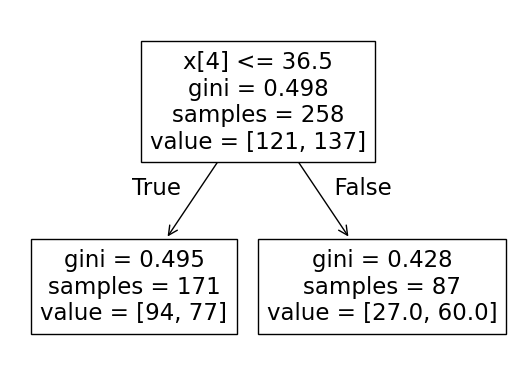

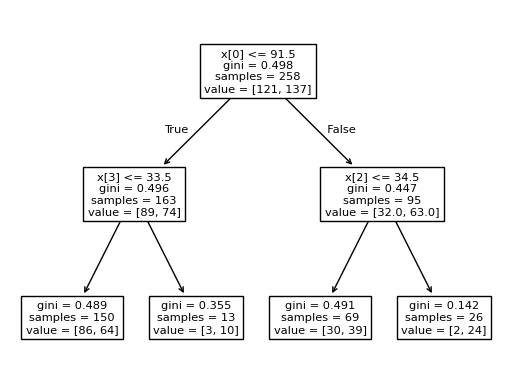

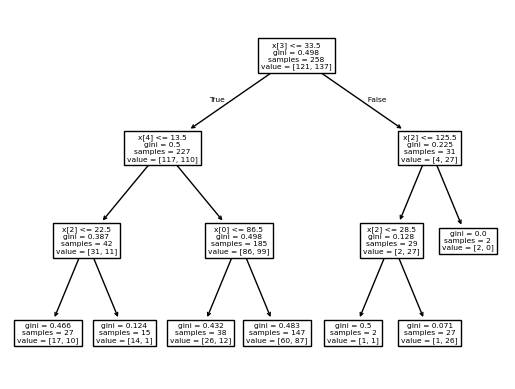

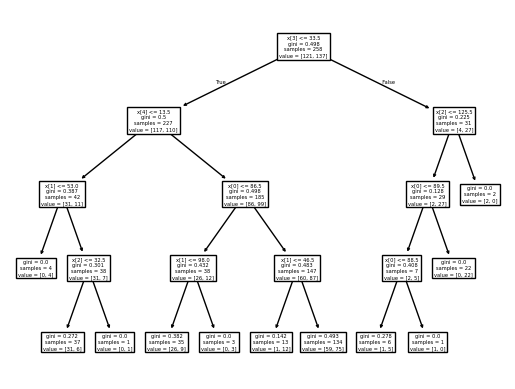

In [38]:
import matplotlib.pyplot as plt
for i in range(1,5):
    dt = DecisionTreeClassifier(max_depth=i)
    dt.fit(X_train, y_train)
    plot_tree(dt)
    plt.show()

In [45]:
dt = DecisionTreeClassifier(max_depth=1)
dt.fit(X_train, y_train)
print(dt.predict(X_test))
dt_ = DecisionTreeClassifier(max_depth=3)
dt_.fit(X_train, y_train)

[0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1
 0 0 0 1 1 0 0 1 0 0 0 0 0]


DecisionTreeClassifier(max_depth=3)

In [46]:
dt.tree_ = dt_.tree_

In [47]:
dt_.predict(X_test)

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [48]:
dt.predict(X_test)


array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [70]:
import numpy as np

def limited_feature_predict(clf, X, max_features):
    """
    Make predictions by limiting the number of features the tree can make.
    
    Parameters:
    clf: Trained decision tree classifier
    X: Feature matrix
    max_splits: Maximum number of features to traverse before making a prediction
    
    Returns:
    predictions: Array of predictions for each sample in X
    """
    tree = clf.tree_
    n_samples = X.shape[0]
    predictions = []
   
    feature_lists = []

    for i in range(n_samples):
        feature_list = []
        node_id = 0  # Start at the root node

        while tree.children_left[node_id] != tree.children_right[node_id]:  # While not a leaf

            # Get the feature to split on and the threshold to compare to
            feature = tree.feature[node_id]

            # Stop if the max number of splits is reached
            if len(set(feature_list + [feature])) > max_features:
                break
            
            feature_list.append(feature)
            threshold = tree.threshold[node_id]

            # Traverse to the left or right child based on feature value
            if X[i, feature] <= threshold:
                node_id = tree.children_left[node_id]
            else:
                node_id = tree.children_right[node_id]

        # After the loop, we are at a node, make a prediction
        # Use the majority class of this node to make a prediction
        predictions.append(tree.value[node_id]) 
        feature_lists.append(feature_list)

    return np.vstack(predictions), feature_lists


In [75]:
y_prob = dt_.predict_proba(X_test)

y_prob2, fl =  limited_feature_predict(dt_, X_test, max_features=3)

y_prob - y_prob2

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.

[Text(0.5769230769230769, 0.875, 'x[3] <= 33.5\ngini = 0.498\nsamples = 258\nvalue = [121, 137]'),
 Text(0.3076923076923077, 0.625, 'x[4] <= 13.5\ngini = 0.5\nsamples = 227\nvalue = [117, 110]'),
 Text(0.4423076923076923, 0.75, 'True  '),
 Text(0.15384615384615385, 0.375, 'x[1] <= 53.0\ngini = 0.387\nsamples = 42\nvalue = [31, 11]'),
 Text(0.07692307692307693, 0.125, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.23076923076923078, 0.125, 'gini = 0.301\nsamples = 38\nvalue = [31, 7]'),
 Text(0.46153846153846156, 0.375, 'x[0] <= 86.5\ngini = 0.498\nsamples = 185\nvalue = [86, 99]'),
 Text(0.38461538461538464, 0.125, 'gini = 0.432\nsamples = 38\nvalue = [26, 12]'),
 Text(0.5384615384615384, 0.125, 'gini = 0.483\nsamples = 147\nvalue = [60, 87]'),
 Text(0.8461538461538461, 0.625, 'x[2] <= 125.5\ngini = 0.225\nsamples = 31\nvalue = [4, 27]'),
 Text(0.7115384615384615, 0.75, '  False'),
 Text(0.7692307692307693, 0.375, 'x[4] <= 46.0\ngini = 0.128\nsamples = 29\nvalue = [2, 27]'),
 Text

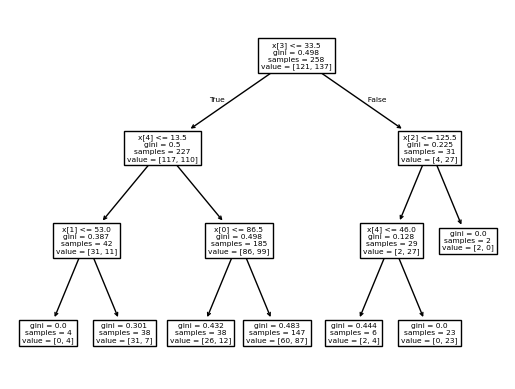

In [72]:
plot_tree(dt_)